In [14]:
import uproot 
import numpy as np
import coffea
from coffea.nanoaod import NanoEvents
from coffea import hist
from coffea.nanoaod.methods.leptons import *

fname = "/uscms/home/therwig/nobackup/public/forDominic/CRAB3_sos_28may2020_testHinoProd_nano.root"
events = NanoEvents.from_file(fname,methods={"ElectronBPark":Electron})

#select electrons and postirons from gen partcles
mask_genele = abs(events.GenPart.pdgId)==11
#Boson as parent
mask_Z_parent = events.GenPart.parent.pdgId == 21
#Neturalino
mask_N_parent = events.GenPart.parent.pdgId == 1000023
#final mask
mask_ele=mask_genele & (mask_Z_parent | mask_N_parent)

#determine delta_R for pairs of electrons
gen_reco_pairs = events.Electron.cross(events.GenPart[mask_ele])
gen_reco_deltar = gen_reco_pairs.i0.delta_r(gen_reco_pairs.i1).min()
#match accordingly
mask_matched = gen_reco_deltar<0.05
mask_unmatched = gen_reco_deltar>=0.05

#delta_R for soft_gen_reco pairs
soft_gen_reco_pairs = events.ElectronBPark.cross(events.GenPart[mask_ele])
soft_gen_reco_deltar = soft_gen_reco_pairs.i0.delta_r(soft_gen_reco_pairs.i1).min()

soft_mask_matched = soft_gen_reco_deltar<0.05
soft_mask_unmatched = soft_gen_reco_deltar>=0.05

#masks for various cuts
mask_looseMVA = events.ElectronBPark.mvaId > 0
mask_tightMVA = events.ElectronBPark.mvaId > 5
mask_ip3d = events.ElectronBPark.ip3d < 5
mask_trkRelIso = events.ElectronBPark.trkRelIso < 2
mask_dxy = np.abs(events.ElectronBPark.dxy) < 0.1
mask_dz = np.abs(events.ElectronBPark.dz) < 15

histo_all = hist.Hist(
            "All",
            hist.Cat("variables", "Variables"),
            hist.Bin("soft_ele", "Soft_ele_pt", 150, 0, 20),
        )

histo_all.fill(variables="denominator", soft_ele = events.ElectronBPark[soft_mask_matched].pt.flatten())



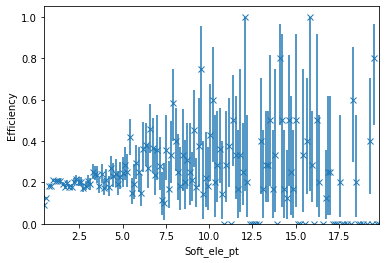

In [21]:
histo_loose = hist.Hist(
            "Efficiency",
            hist.Cat("variables", "Variables"),
            hist.Bin("soft_ele", "Soft_ele_pt", 150, 0, 20),
        )
mask_loose = soft_mask_matched & mask_looseMVA
histo_loose.fill(variables="all", soft_ele = events.ElectronBPark[mask_loose].pt.flatten())
%matplotlib inline
hist.plotratio(num=histo_loose.integrate("variables"), denom=histo_all.integrate("variables"), error_opts={"marker": "x"})